In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,5)
AGENTS = ["B1","B2","B3","B4",
          "C1","C2","C3","C4",
          "D1","D2","D3","D4",
          "E1","E2","E3","E4"]   # any 16-agent ordering you used


In [25]:
path = "ckpt/block_normal/Ours_Attention/400_attn_per_episode.npy"
A = np.load(path)           # shape (E,16,16)
print(f"Loaded {A.shape[0]} episodes   matrix size {A.shape[1:]}")

# quick sanity-check: rows sum to 1 ?
print( np.round(A[0].sum(-1), 3) )     # should all be 1.000


Loaded 10 episodes   matrix size (16, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


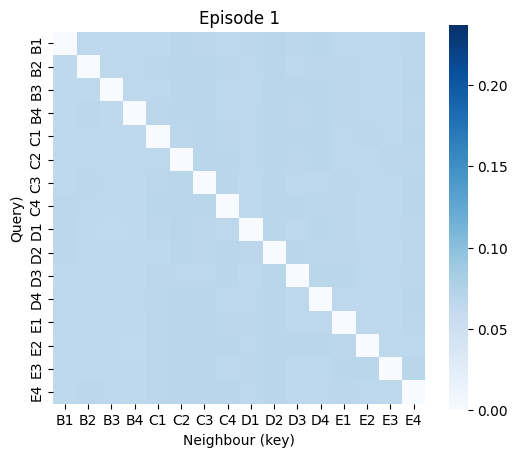

In [26]:
def show_heat(ep=0, cmap="Blues"):
    sns.heatmap(A[ep], vmax=A.max(), vmin=0,
                xticklabels=AGENTS, yticklabels=AGENTS,
                cmap=cmap, square=True, cbar=True)
    plt.title(f"Episode {ep+1}")
    plt.ylabel("Query)"); plt.xlabel("Neighbour (key)")
    plt.show()

show_heat(0)     # first episode


[[0.         0.08192667 0.09038657 0.05153595 0.06625295 0.05020959
  0.05398273 0.05905537 0.06791427 0.06804001 0.06452629 0.08681086
  0.08046712 0.06373745 0.04598359 0.06917058]
 [0.06740758 0.         0.09172058 0.05586665 0.06538932 0.05581728
  0.05987734 0.05909214 0.06635798 0.06528583 0.06386638 0.08644257
  0.08045328 0.06452896 0.04914267 0.06875144]
 [0.07340872 0.08263185 0.         0.05294491 0.07270104 0.04866185
  0.0538656  0.06046829 0.06645098 0.06661934 0.06407809 0.09200978
  0.08212866 0.0622786  0.04555308 0.07619926]
 [0.06567504 0.08124902 0.09232396 0.         0.06898244 0.05009378
  0.05136018 0.05899578 0.06403265 0.06189907 0.06098412 0.08863235
  0.07949583 0.06369485 0.04365944 0.06892151]
 [0.06725962 0.08279921 0.09037454 0.05460416 0.         0.05462765
  0.05097795 0.05774627 0.06526641 0.06419666 0.06363745 0.08620945
  0.07991306 0.06582973 0.04805445 0.06850346]
 [0.06618638 0.08275919 0.09072781 0.05239826 0.06625999 0.
  0.05204349 0.05715334 0

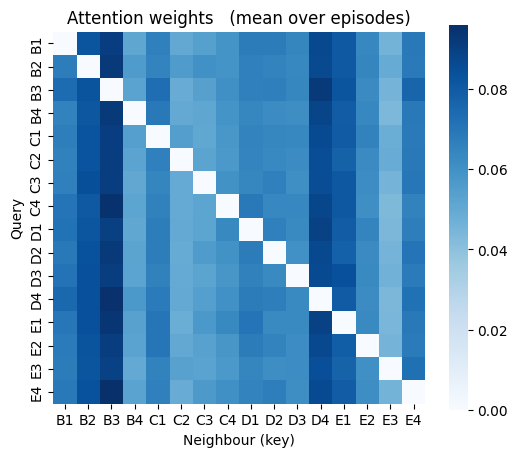

In [27]:
A_mean = A.mean(0)          # (16,16)
print(A_mean)
sns.heatmap(A_mean, vmax=A_mean.max(), vmin=0,
            xticklabels=AGENTS, yticklabels=AGENTS,
            cmap="Blues", square=True)
plt.title("Attention weights   (mean over episodes)")
plt.ylabel("Query"); plt.xlabel("Neighbour (key)")
plt.show()


In [28]:
k = 3
rows = []
for i,recv in enumerate(AGENTS):
    idx = np.argsort(A_mean[i])[::-1][:k]
    rows.append({"Agent":recv,
                 "Top-k": ", ".join([AGENTS[j] for j in idx]),
                 "Weights": ", ".join([f"{A_mean[i,j]:.2f}" for j in idx])})
pd.DataFrame(rows)


,Agent,Top-k,Weights
0,B1,"B3, D4, B2","0.09, 0.09, 0.08"
1,B2,"B3, D4, E1","0.09, 0.09, 0.08"
2,B3,"D4, B2, E1","0.09, 0.08, 0.08"
3,B4,"B3, D4, B2","0.09, 0.09, 0.08"
4,C1,"B3, D4, B2","0.09, 0.09, 0.08"
5,C2,"B3, D4, B2","0.09, 0.09, 0.08"
6,C3,"B3, D4, B2","0.09, 0.08, 0.08"
7,C4,"B3, D4, E1","0.09, 0.09, 0.08"
8,D1,"B3, D4, B2","0.09, 0.09, 0.08"
9,D2,"B3, D4, B2","0.09, 0.09, 0.08"


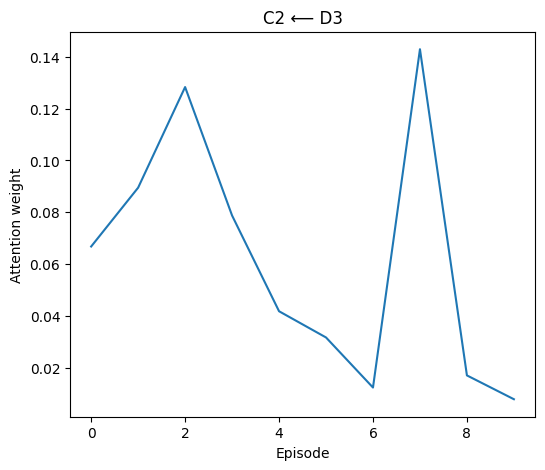

In [29]:
pair = ("C2","D3")        # receiver, neighbour
i, j = AGENTS.index(pair[0]), AGENTS.index(pair[1])

plt.plot(A[:, i, j])
plt.xlabel("Episode"); plt.ylabel("Attention weight")
plt.title(f"{pair[0]} ⟵ {pair[1]}")
plt.show()


In [30]:
def grid_heat(Amean, idx, ax=None, cmap="Blues"):
    """
    Amean : ndarray (16,16)
    idx   : int                
    """

    if ax is None:
        ax = plt.gca()

    # 1-D → 4×4 (column-major) → transpose → flip rows
    mat = Amean[idx].reshape(4, 4).T[::-1]      #   ←★ ONLY 1-LINE CHANGE

    sns.heatmap(mat,
                annot=True, fmt=".02f",
                cmap=cmap, square=True, cbar=False,
                xticklabels=["0","1","2","3"],
                yticklabels=["0","1","2","3"][::-1],
                ax=ax)
    ax.set_title(f"Agent {AGENTS[idx]}")
    ax.set_xlabel("col →")
    ax.set_ylabel("row ↑")



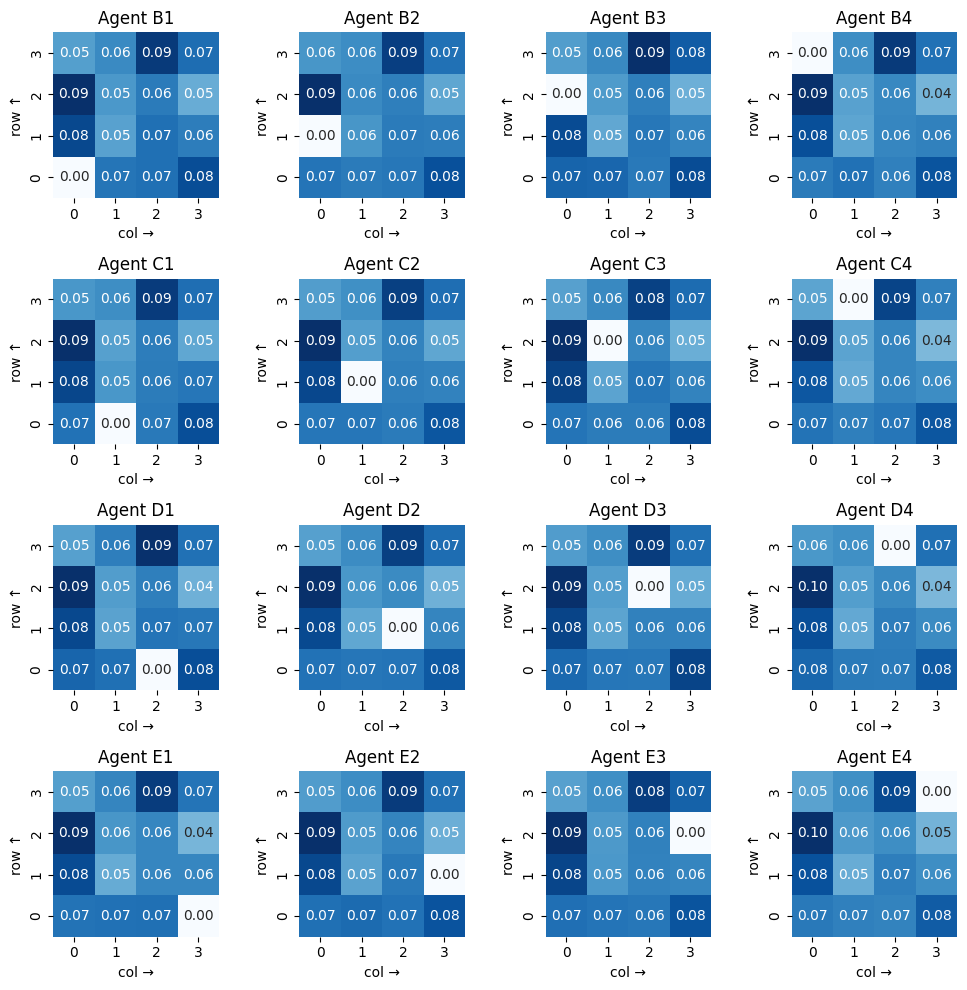

In [31]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for k,ax in enumerate(axes.ravel()):
    grid_heat(A_mean, k, ax=ax)
plt.tight_layout(); plt.show()


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.01960117e-04 3.01960117e-04 3.01960117e-04
 3.01960117e-04 3.019601

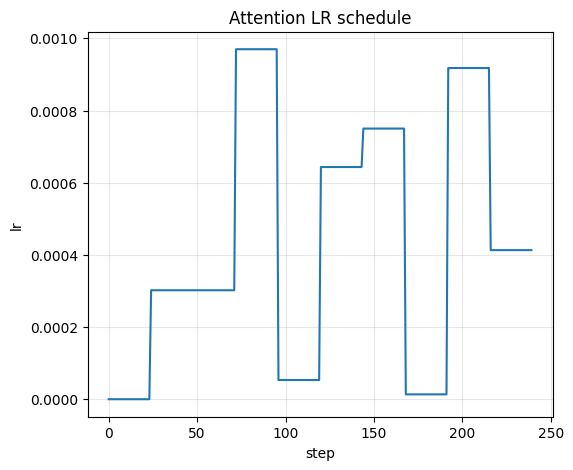

In [32]:
lrs = np.load("ckpt/block_normal/Ours_Attention/400_attn_lr_history.npy")
plt.plot(lrs)
plt.title("Attention LR schedule")
plt.xlabel("step"); plt.ylabel("lr")
plt.grid(alpha=.3)
print(lrs)
